In [1]:
import pandas as pd
import cv2
import supervision as sv
import numpy as np
import os
import pickle as pl
import torch
import segmentation_models_pytorch as smp

In [2]:
main_path = "/root/Master_Thesis/"
dataframes_path = main_path + "data/dataframes/"
trained_models = main_path + "scripts/notebooks/trained_models/"
notebooks_path = main_path + "scripts/notebooks/"

In [5]:
# df_name = "brain_df"
# train_df = pd.read_csv(dataframes_path+"brain_df_train.csv")
# test_df = pd.read_csv(dataframes_path+"brain_df_test.csv")

df_name = "lung_df"
train_df = pd.read_csv(dataframes_path+"lung_df_train.csv")
test_df = pd.read_csv(dataframes_path+"lung_df_test.csv")

In [4]:
# voters_128_22_100 = [trained_models + f"Brain_MRI_segmentation/voters/100/voters_128_22/model_{i}.pt" for i in range(1,10)]
# main_128_22_100 = trained_models + "Brain_MRI_segmentation/voters/100/voters_128_22/main_Unet.pt"
# voters_128_22_100.append(main_128_22_100)

# voters_128_22_200 = [trained_models + f"Brain_MRI_segmentation/voters/200/voters_128_22/model_{i}.pt" for i in range(1,10)]
# main_128_22_200 = trained_models + "Brain_MRI_segmentation/voters/200/voters_128_22/main_Unet.pt"
# voters_128_22_200.append(main_128_22_200)

# voters_128_22_300 = [trained_models + f"Brain_MRI_segmentation/voters/300/voters_128_22/model_{i}.pt" for i in range(1,10)]
# main_128_22_300 = trained_models + "Brain_MRI_segmentation/voters/300/voters_128_22/main_Unet.pt"
# voters_128_22_300.append(main_128_22_300)


# main_Unet_128_22_no_voting_100 = trained_models + "Brain_MRI_segmentation/withSAM_NoVoting/100/main_Unet_128_22.pt"
# main_Unet_128_22_no_voting_200 = trained_models + "Brain_MRI_segmentation/withSAM_NoVoting/200/main_Unet_128_22.pt"
# main_Unet_128_22_no_voting_300 = trained_models + "Brain_MRI_segmentation/withSAM_NoVoting/300/main_Unet_128_22.pt"

In [3]:
voters_128_29_100 = [trained_models + f"Lung_Tumor_Segmentation/voters/100/voters_128_29/model_{i}.pt" for i in range(1,10)]
main_128_29_100 = trained_models + "Lung_Tumor_Segmentation/voters/100/voters_128_29/main_Unet.pt"
voters_128_29_100.append(main_128_29_100)


main_Unet_128_29_no_voting_100 = trained_models + "Lung_Tumor_Segmentation/withSAM_NoVoting/100/main_Unet_128_29.pt"

In [6]:
params = {'n_epoch': 35,
          'train_args':{'batch_size': 4, 'num_workers': 1},
          'test_args':{'batch_size': 256, 'num_workers': 1},
          'optimizer_args':{'lr': 5e-3, 'momentum': 0.9},
          'use_sam': True,
          'use_predictor': True,
          'use_generator': False,
          'init_set_size': 100,
          'rounds': 30,
          "activate_sam_at_round":1, 
          "img_size":(128, 128),
          "voting" : True,
          "pre_trained": True,
          "dataset": "Lung_Tumor_Segmentation"}

if params["init_set_size"] == len(train_df):
    params["training_type"] = "no_active"
elif not params["use_sam"]:
    params["training_type"] = "no_sam"
elif params["voting"]:
    params["training_type"] = "voters"
else:
    params["training_type"]="withSAM_NoVoting"

if params["training_type"] == "no_active":
    if params["pre_trained"]:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/no_active/pre_trained_Unet_{params["img_size"][0]}.pt'
    else:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/no_active/not_pre_trained_Unet_{params["img_size"][0]}.pt'
else:
    params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/{params["training_type"]}/{params["init_set_size"]}'
    
params['test_set_size'] = len(test_df)
params['df'] = df_name
params['query_num'] = int(0.05 * params['init_set_size'])
if params['query_num'] == 0:
    params['query_num'] = 1
params["strategy"] = "MarginSampling"

if params["training_type"] == "voters":
    params["model_path"] = f'{params["model_path"]}/voters_{params["img_size"][0]}'

In [7]:
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"

In [8]:
import sys
sys.path.append('../src')
from strategies import *
sam = SAMOracle(checkpoint_path=sam_path, img_size=params["img_size"])

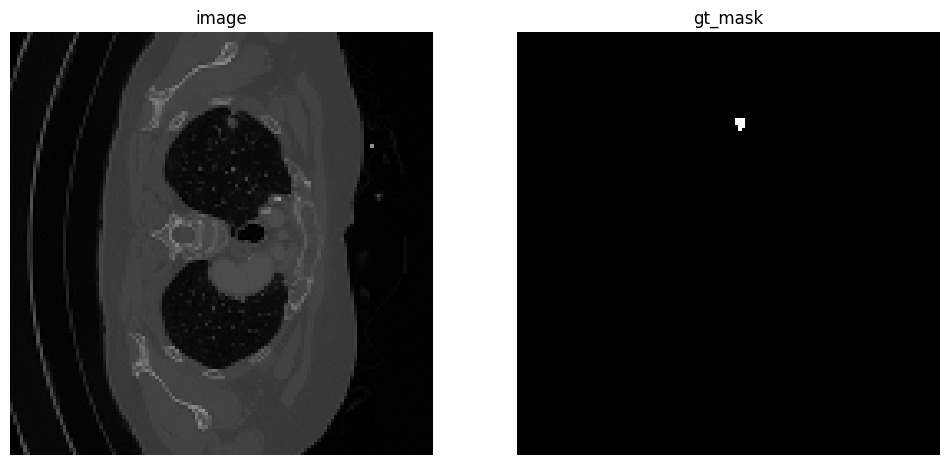

In [21]:
##Brain tumor
# close results = 0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24
# different results = 4, 14, 16, 25, 26, 27

##Lung tumor
# close results = 0
# different results = 

i=1
import supervision as sv

image = np.load(test_df["images"][i], allow_pickle=True)
gt_mask = np.load(test_df["masks"][i], allow_pickle=True)
# gt_mask = np.sum(gt_mask, axis=2)
sv.plot_images_grid(
    images=[image, gt_mask],
    grid_size=(1, 2),
    titles=['image', 'gt_mask']
)

In [22]:
test_df_slice = test_df[i:i+1]
def get_data(handler, train_df, test_df):
    return Data(train_df["images"].to_list(), train_df["masks"].to_list(), test_df["images"].to_list(), test_df["masks"].to_list(), handler, img_size=params["img_size"], df=train_df, path= main_path+"/data/processed/", use_sam=params['use_sam'])

from custom_datasets import *

data = get_data(Handler, train_df, test_df_slice)
data.initialize_labels(params["init_set_size"])

model = smp.create_model(
            'Unet', encoder_name='resnet34', in_channels=3, classes = 1
        )

net = Net(model, params, device = torch.device("cuda"))


In [23]:
def predict(net, model_state:str):
    net.net.load_state_dict(torch.load(model_state))
    net.clf = net.net.to(torch.device("cuda"))
    mask = net.predict(data.get_test_data())[0]
    mask = (mask.squeeze().cpu().sigmoid()> 0.5).float()
    
    return mask

In [24]:
def get_boxes(mask):
    if torch.is_tensor(mask):
        mask = mask.numpy()
        mask = np.array(mask, np.uint8)
    # _, thresh = cv2.threshold(mask, 0.5, 1, 0)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        box = np.array([x, y, x+w, y+h])
        cnts.append(box)
    return np.array(cnts)   

In [25]:
# voters_128_22_100_masks = [predict(net, path) for path in voters_128_22_100]
# voters_128_22_200_masks = [predict(net, path) for path in voters_128_22_200]
# voters_128_22_300_masks = [predict(net, path) for path in voters_128_22_300]

# main_Unet_128_22_no_voting_100_mask = predict(net, main_Unet_128_22_no_voting_100)
# main_Unet_128_22_no_voting_200_mask = predict(net, main_Unet_128_22_no_voting_200)
# main_Unet_128_22_no_voting_300_mask = predict(net, main_Unet_128_22_no_voting_300)

voters_128_29_100_masks = [predict(net, path) for path in voters_128_29_100]

main_Unet_128_29_no_voting_100_mask = predict(net, main_Unet_128_29_no_voting_100)

In [26]:
# voters_128_22_100_boxes = [get_boxes(mask) for mask in voters_128_22_100_masks]
# voters_128_22_200_boxes = [get_boxes(mask) for mask in voters_128_22_200_masks]
# voters_128_22_300_boxes = [get_boxes(mask) for mask in voters_128_22_300_masks]

# main_Unet_128_22_no_voting_100_boxes = get_boxes(main_Unet_128_22_no_voting_100_mask)
# main_Unet_128_22_no_voting_200_boxes = get_boxes(main_Unet_128_22_no_voting_200_mask)
# main_Unet_128_22_no_voting_300_boxes = get_boxes(main_Unet_128_22_no_voting_300_mask)

voters_128_29_100_boxes = [get_boxes(mask) for mask in voters_128_29_100_masks]

main_Unet_128_29_no_voting_100_boxes = get_boxes(main_Unet_128_29_no_voting_100_mask)

In [27]:
# main_Unet_128_22_no_voting_100_sam = sam.get_mask(img_path=test_df_slice["images"][i], boxes=main_Unet_128_22_no_voting_100_boxes)[0]
# print("main_Unet_128_22_no_voting_100_sam")
# main_Unet_128_22_no_voting_200_sam = sam.get_mask(img_path=test_df_slice["images"][i], boxes=main_Unet_128_22_no_voting_200_boxes)[0]
# print("main_Unet_128_22_no_voting_200_sam")
# main_Unet_128_22_no_voting_300_sam = sam.get_mask(img_path=test_df_slice["images"][i], boxes=main_Unet_128_22_no_voting_300_boxes)[0]
# print("main_Unet_128_22_no_voting_300_sam")


main_Unet_128_29_no_voting_100_sam = sam.get_mask(img_path=test_df_slice["images"][i], boxes=main_Unet_128_29_no_voting_100_boxes)[0]
print("main_Unet_128_29_no_voting_100_sam")

main_Unet_128_29_no_voting_100_sam


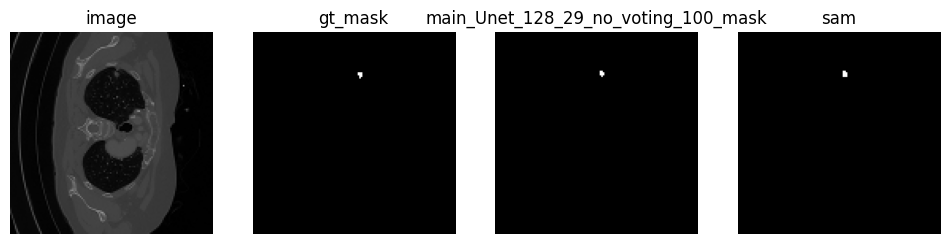

In [28]:
# sv.plot_images_grid(
#     images=[image, gt_mask, main_Unet_128_22_no_voting_100_mask, main_Unet_128_22_no_voting_100_sam],
#     grid_size=(1, 4),
#     titles=['image', 'gt_mask', 'main_Unet_128_22_no_voting_100_mask', 'sam']
# )

# sv.plot_images_grid(
#     images=[image, gt_mask, main_Unet_128_22_no_voting_200_mask, main_Unet_128_22_no_voting_200_sam],
#     grid_size=(1, 4),
#     titles=['image', 'gt_mask', 'main_Unet_128_22_no_voting_200_mask', 'sam']
# )
# sv.plot_images_grid(
#     images=[image, gt_mask, main_Unet_128_22_no_voting_300_mask, main_Unet_128_22_no_voting_300_sam],
#     grid_size=(1, 4),
#     titles=['image', 'gt_mask', 'main_Unet_128_22_no_voting_300_mask', 'sam']
# )

sv.plot_images_grid(
    images=[image, gt_mask, main_Unet_128_29_no_voting_100_mask, main_Unet_128_29_no_voting_100_sam],
    grid_size=(1, 4),
    titles=['image', 'gt_mask', 'main_Unet_128_29_no_voting_100_mask', 'sam']
)


In [29]:
# voters_128_22_100_sam =[sam.get_mask(img_path=test_df_slice["images"][i], boxes=boxes)[0] for boxes in voters_128_22_100_boxes]
# print("voters_128_22_100_sam")
# voters_128_22_200_sam =[sam.get_mask(img_path=test_df_slice["images"][i], boxes=boxes)[0] for boxes in voters_128_22_200_boxes]
# print("voters_128_22_200_sam")
# voters_128_22_300_sam =[sam.get_mask(img_path=test_df_slice["images"][i], boxes=boxes)[0] for boxes in voters_128_22_300_boxes]
# print("voters_128_22_300_sam")

voters_128_29_100_sam =[sam.get_mask(img_path=test_df_slice["images"][i], boxes=boxes)[0] for boxes in voters_128_29_100_boxes]
print("voters_128_29_100_sam")

voters_128_29_100_sam


Init_set = 100


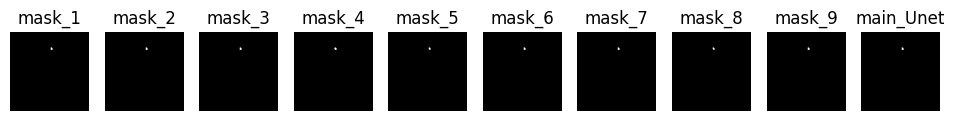

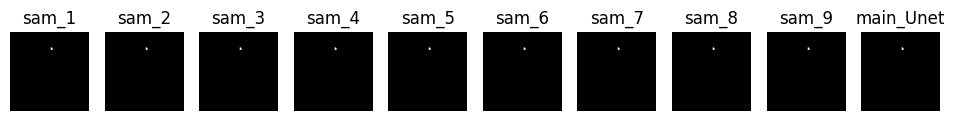

In [30]:
titles = [f"mask_{i}" for i in range(1,10)]
titles.append("main_Unet")


sam_titles = [f"sam_{i}" for i in range(1,10)]
sam_titles.append("main_Unet")

# print("Init_set = 100")
# sv.plot_images_grid(
#     images=voters_128_22_100_masks,
#     grid_size=(1, len(titles)),
#     titles=titles
# )

# sv.plot_images_grid(
#     images=voters_128_22_100_sam,
#     grid_size=(1, len(titles)),
#     titles=sam_titles
# )


# print("Init_set = 200")
# sv.plot_images_grid(
#     images=voters_128_22_200_masks,
#     grid_size=(1, len(titles)),
#     titles=titles
# )

# sv.plot_images_grid(
#     images=voters_128_22_200_sam,
#     grid_size=(1, len(titles)),
#     titles=sam_titles
# )

# print("Init_set = 300")
# sv.plot_images_grid(
#     images=voters_128_22_300_masks,
#     grid_size=(1, len(titles)),
#     titles=titles
# )

# sv.plot_images_grid(
#     images=voters_128_22_300_sam,
#     grid_size=(1, len(titles)),
#     titles=sam_titles
# )

print("Init_set = 100")
sv.plot_images_grid(
    images=voters_128_29_100_masks,
    grid_size=(1, len(titles)),
    titles=titles
)

sv.plot_images_grid(
    images=voters_128_29_100_sam,
    grid_size=(1, len(titles)),
    titles=sam_titles
)

In [31]:
# sum_100 = np.array(voters_128_22_100_sam).sum(axis=0)
# sum_200 = np.array(voters_128_22_200_sam).sum(axis=0)
# sum_300 = np.array(voters_128_22_300_sam).sum(axis=0)

# majority_100 = np.array((sum_100.squeeze() > 5), dtype=np.float32)
# majority_200 = np.array((sum_200.squeeze() > 5), dtype=np.float32)
# majority_300 = np.array((sum_300.squeeze() > 5), dtype=np.float32)


sum_100 = np.array(voters_128_29_100_sam).sum(axis=0)

majority_100 = np.array((sum_100.squeeze() > 5), dtype=np.float32)

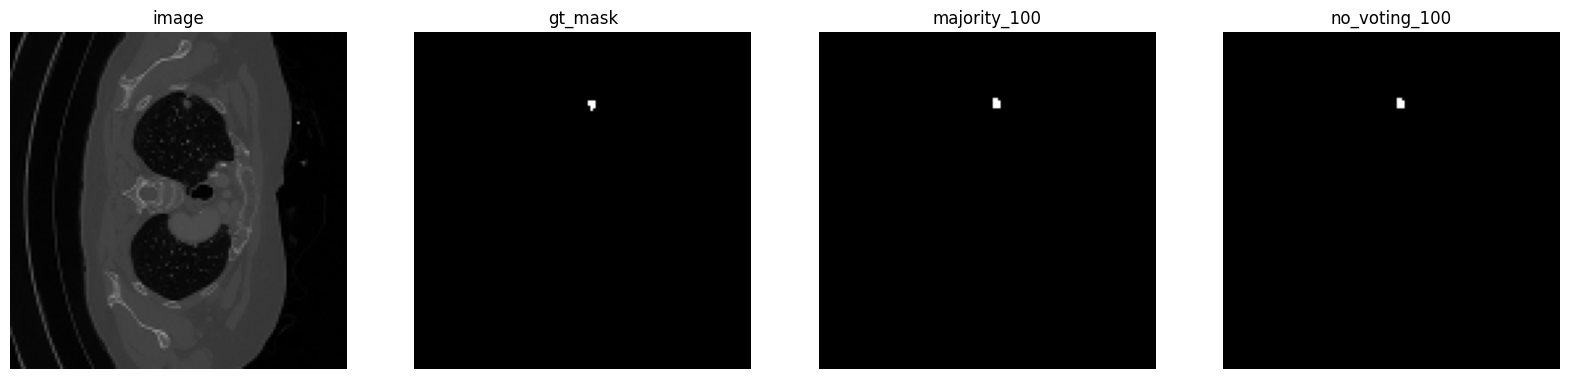

In [32]:
# sv.plot_images_grid(
#     images=[image, gt_mask, majority_100, majority_200, majority_300, main_Unet_128_22_no_voting_100_sam, main_Unet_128_22_no_voting_200_sam, main_Unet_128_22_no_voting_300_sam],
#     grid_size=(1, 8),
#     titles=["image", "gt_mask", "majority_100", "majority_200", "majority_300", "no_voting_100", "no_voting_200", "no_voting_300"],
#     size=(20,20)
    
# )

sv.plot_images_grid(
    images=[image, gt_mask, majority_100, main_Unet_128_29_no_voting_100_sam],
    grid_size=(1, 4),
    titles=["image", "gt_mask", "majority_100", "no_voting_100"],
    size=(20,20)
    
)

In [33]:
# paths=[]
# for dirname, _, filenames in os.walk(main_path +"data/processed/Brain_MRI_segmentation/oracle/"):

#     for filename in filenames:
#         paths.append(os.path.join(dirname, filename))

# idx=[]
# for i, path in enumerate(train_df["oracle"]):
#     if path in paths:
#         idx.append(i)

# print(len(paths), len(idx))

# imgs=[]
# gt_masks = []
# paths=[]
# oracles = []
# for i in idx:
#     imgs.append(cv2.imread(train_df["images"][i]))
#     gt_masks.append(cv2.resize(cv2.cvtColor(cv2.imread(train_df["masks"][i]), cv2.COLOR_BGR2GRAY), (128,128), interpolation=cv2.INTER_CUBIC))       
#     oracles.append(np.load(train_df["oracle"][i], allow_pickle=True))
#     paths.append(train_df["oracle"][i])

# for i in range(len(oracles)):
#     if oracles[i].shape!= (128, 128):
#         print(i, oracles[i].shape)

In [34]:
# gtmasks= torch.tensor(np.array(gt_masks)).unsqueeze_(1)
# preds = torch.tensor(np.array(oracles)).unsqueeze_(1)

# tp, fp, fn, tn = smp.metrics.get_stats(preds.long(), gtmasks.long(), mode="binary", threshold=0.5)

# # Calculate IoU and F1-score
# iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
# accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
# f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
# recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
# precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

# print(f"Oracles to GT: iou_score = {iou:.2f}, accuracy = {accuracy:.2f}, precision = {precision:.2f}, recall = {recall:.2f}, f1_score = {f1:.2f}")

In [35]:
# i=0
# for img, gt_mask, oracle in zip(imgs[i:i+50], gt_masks[i:i+50], oracles[i:i+50]):
#     sv.plot_images_grid(
#         images=[img, gt_mask, oracle],
#         grid_size=(1, 3),
#         titles =["image", "gt_mask", "oracle"]
#     )

In [36]:
# def load_masks(paths, voting_dir):
#     masks=[]
#     for path in paths:
#         path = path.split("/")
#         path[-2] = voting_dir
#         path = "/".join(path)
#         if os.path.isfile(path):
#             # mask = np.load(path, allow_pickle=True)
            
#             # if len(mask.shape) == 3:
#             #     mask = mask[0]
        
#             # masks.append(mask)
#             masks.append(path)
#     return masks

In [37]:
# def plotRoundMasks(round, df):
#     oracle_mv_128_paths = []
#     for dirname, _, filenames in os.walk(main_path +f"data/processed/oracle_mv_128_{round}/"):

#         for filename in filenames:
#             oracle_mv_128_paths.append(os.path.join(dirname, filename))
            
#     oracle_mv_128_paths = load_masks(oracle_mv_128_paths, "oracle")

#     idx=[]
#     for i, path in enumerate(df["oracle"]):
#         if path in oracle_mv_128_paths:
#             idx.append(i)
            
#     imgs=[]
#     gt_masks = []
#     paths=[]
#     oracles = []
#     for i in idx:
#         imgs.append(cv2.imread(df["images"][i]))
#         gt_masks.append(cv2.resize(cv2.cvtColor(cv2.imread(df["masks"][i]), cv2.COLOR_BGR2GRAY), (128,128), interpolation=cv2.INTER_CUBIC))       
#         oracles.append(np.load(df["oracle"][i], allow_pickle=True))
        
#     for img, gt_mask, oracle in zip(imgs, gt_masks, oracles):
#         sv.plot_images_grid(
#             images=[img, gt_mask, oracle],
#             grid_size=(1, 3),
#             titles =["image", "gt_mask", "oracle"]
#         )



In [38]:
# plotRoundMasks(1 , train_df,)

In [39]:
# oracle_mv_128_1 = load_masks(paths, "oracle_mv_128_1")
# oracle_mv_128_2 = load_masks(paths, "oracle_mv_128_2")
# oracle_mv_128_3 = load_masks(paths, "oracle_mv_128_2")
# oracle_mv_128_4 = load_masks(paths, "oracle_mv_128_4")

In [40]:
# print("Images")
# sv.plot_images_grid(
#     images=imgs,
#     grid_size=(1, len(imgs)),
# )

# print("Gt_Masks")
# sv.plot_images_grid(
#     images=gt_masks,
#     grid_size=(1, len(gt_masks)),
# )

# print("Oracles")
# sv.plot_images_grid(
#     images=oracles,
#     grid_size=(1, len(oracles)),
# )

In [41]:

# i = idx[98]
# img = cv2.imread(train_df["images"][i])
# gt_mask = cv2.imread(train_df["masks"][i])
# oracle = np.load(train_df["oracle"][i], allow_pickle=True)

# sv.plot_images_grid(
#     images=[img, gt_mask, oracle],
#     grid_size=(1, 3)
# )

# train_df["oracle"][i]

In [42]:
# def checkOutput(all_idx, bad_idx):
#     for i in bad_idx:
#         img = cv2.imread(train_df["images"][i])
#         gt_mask = cv2.imread(train_df["masks"][i])
#         if os.path.isfile(train_df["oracle"][i]):
#             oracle = np.load(train_df["oracle"][i], allow_pickle=True)
#             sv.plot_images_grid(
#                 images=[img, gt_mask, oracle],
#                 grid_size=(1, 3)
#             )
#             x = input("Do you want to delete?")
#             if x =='n':
#                 continue
#             else:
#                 os.remove(train_df["oracle"][i])
        

In [43]:
# # bad_idx = [202, 205, 212, 213, 216, 219]
# i = 0
# checkOutput(idx, idx[i:i+100])

In [44]:
# def plotComparison(imgs, mv_masks, no_mv_masks, wmv_masks, gt_masks):
#     print("Images")
#     sv.plot_images_grid(
#         images=imgs,
#         grid_size=(1, len(imgs)),
#     )

#     print("Masks with Majority Voting")
#     sv.plot_images_grid(
#         images=mv_masks,
#         grid_size=(1, len(mv_masks)),
#     )

#     print("Masks without Majority Voting")
#     sv.plot_images_grid(
#         images=no_mv_masks,
#         grid_size=(1, len(no_mv_masks)),
#     )

#     print("Masks wit Weighted Majority Voting")
#     sv.plot_images_grid(
#         images=wmv_masks,
#         grid_size=(1, len(wmv_masks)),
#     )


#     print("GT_Masks")
#     sv.plot_images_grid(
#         images=gt_masks,
#         grid_size=(1, len(imgs)),
#     )

In [45]:
# plotComparison(imgs, oracle_mv_128_1, oracle_mv_128_2, oracle_mv_128_3, gt_masks)

In [46]:
# round_2_idx = [1406, 2442,  533,  536, 1425]

# imgs_2=[]
# gt_masks_2 = []
# paths=[]
# for i in round_2_idx:
#     # print(train_df["images"][i])
#     imgs_2.append(cv2.imread(train_df["images"][i]))
#     gt_masks_2.append(cv2.imread(train_df["masks"][i]))
#     paths.append(train_df["oracle"][i])

In [47]:
# mv_masks_128 = load_masks(paths, "oracle_mv_128")
# no_mv_masks_128 = load_masks(paths, "oracle_no_mv_128")
# wmv_masks_128 = load_masks(paths, "oracle_wmv_128")

In [48]:
# plotComparison(imgs_2, mv_masks_128, no_mv_masks_128, wmv_masks_128, gt_masks_2)

In [49]:
# round_3_idx = [1646, 1679, 1674, 1668, 1662]

# imgs_3=[]
# gt_masks_3 = []
# paths=[]
# for i in round_3_idx:
#     # print(train_df["images"][i])
#     imgs_3.append(cv2.imread(train_df["images"][i]))
#     gt_masks_3.append(cv2.imread(train_df["masks"][i]))
#     paths.append(train_df["oracle"][i])

In [50]:
# mv_masks_128_3 = load_masks(paths, "oracle_mv_128_3")
# no_mv_masks_128_3 = load_masks(paths, "oracle_no_mv_128_3")
# wmv_masks_128_3 = load_masks(paths, "oracle_wmv_128_3")

In [51]:
# plotComparison(imgs_3, mv_masks_128_3, no_mv_masks_128_3, wmv_masks_128_3, gt_masks_3)